[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eirasf/GCED-AA3/blob/main/lab3/lab3.ipynb)

# Modelos *Ensemble*

Una de las últimas tendencias dentro de lo que serían los modelos de inteligencia artificial viene a resumirse como "el conocimiento del conjunto o la multitud". Lo que viene a definir esta frase, un tanto popular, es el uso de multitud de modelos denominados "débiles" en un metaclasificador. El objetivo es generar un modelo "fuerte" en base al conocimiento extraído por los modelos "débiles". Por ejemplo, aunque se detallará más adelante, en un *Random Forest* se desarrollan múltiples *Decision Trees* mucho más simples. La combinación de estos en el *Random Forest* excede el rendimiento de cualquiera de los modelos individuales. Los modelos surgidos de está manera, como metaclasificadores o metaregresores  reciben el nombre genérico de modelos *Ensemble*.

Un hecho a destacar es el hecho de que estos modelos pueden no limitarse unicamente a los arboles de decisión, por contra pueden componerse de cualquier tipo de modelo de aprendizaje automático que se ha visto previamente. Incluso pueden ser modelos mixtos donde no todos los modelos se hayan obtenido de la misma manera, si no que pueden ser creados mediante el uso combinado de varias técnicas como pueden ser el K-NN, SVM, etc.

En la presente unidad se va a explorar varias maneras de como generar los modelos y como combinarlos posteriormente. Así mismo, se verán dos de las técnicas más habituales dentro de estos modelos *ensemble* como son el _Random Forest_, y _XGBoost_.

## Preparar los datos
En este tutorial vamos a utilizar los mismos datos que se emplearon en el priemro de los tutoriales, así que si ya los tiene descargados puede copiarlos y cargarlos en la carpeta o, dado el pequeo tamaño de los mismos, volver a descargarlos con el  siguiente código.

In [2]:
import os
import pandas as pd

def load_data(folder, file, url):
    '''
        Función de utilidad que comprueba si los datos están presentes en el directorio, 
        en caso de que no estén los descarga y en cualquiera de los casos los carga.
    '''
    
    #Comprobación de seguridad
    if os.path.exists(folder) and not os.path.isdir(folder):
        raise(Exception("The name of the root folder is already in use"))
        
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    file_path = os.path.join(folder, file)
    
    if not os.path.isfile(file_path):
        print(f'Downloading'.ljust(75,'.'), end='', flush=True)
        import urllib.request
        urllib.request.urlretrieve(url,file_path)
        print(f"Done!")
        
    return pd.read_csv(file_path, delimiter=',', header=None)

data_folder = '_data_'
file_name = 'sonar.all_data'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'


data = load_data(data_folder,file_name, url)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


A modo de recordatorio, se trata de un problema clásico de *machine learning* del repositorio UCIde la univerisidade de Berkley.  Se denomina informalmente como **¿Roca o Mina?** y consta de 111 patrones correspondientes a rocas y 97 a minas acuáticas. Cada uno de los patrones consta de 60 medidas numéricas correspondientes a un tramo de las fecuencias emitidas por el sonar. Estos valores se encuentran ya entre 0.0. y 1.0. Dichas medidas representan el valor de la energia de diferentes rangos de longitud de onda para un cierto periodo de tiempo.

A mayores de esta carga es conveniente hacer una exploración inicial con el fin de detectar posibles problemas en los datos como los comentados en teoría, es decir, datos atípicos o no normalizados, datos ausentes de cualquiera de los 3 subtipos (MCAR, MAR, MNAR) o posibles sesgos que pudieran aparecer. Dicha exploración en el caso de disponer como en este caso de un _Dataframe_ tipo `pandas`, se puede hacer comenzar con las siguientes líneas de código:

In [3]:
#Comprobar el número de medidas y variables, así como los tipos utilizados para los diferentes datos
data.info(memory_usage='deep')

#Comprobar los rangos de las variables 
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507,NaN
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031,NaN
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600,NaN
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100,NaN
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300,NaN
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525,NaN


Como se puede ver en la salida anterior, se dispone de las mencionadas características ordenadas en 60 columnas numéricas correspondientes a cada uno de los agregados de las longitudes de onda.  Por contra, la última columna se corresponde con una categoria o columna de datos discretos en la que se encuentra consignado un valor R cuando se trata de una una roca y una M cuando es una mina.
Existen diferentes maneras de tratar este problema. Algunos ejemplos serían cambiar el tipo `object` de la columna por `category`, se podría hacer un *one-hot encoded* creando una columna para cada uno de las posibilidades. En este caso, se ha optado por realizar una codificación binaria en un único valor ya que se trata de un problema de clasificación binaria y con eso será suficiente. Así que se le asignará un valor de *True* o *False* dentro de una columna denominada **Mina**. En concreto, todos aquellos elementos que coincidan en la columna 60 con una M tendrán el valor de *True* y en caso contrario sera un *False*.

In [4]:
data['Mina'] = (data[60]=='M')
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,Mina
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R,False
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R,False
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R,False
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R,False
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R,False


El siguiente paso será el preparar los conjuntos de datos de entrada y salida. Como se ve a continuación:

In [5]:
import numpy as np

#Recoger las 60 primeras mediciones y convertirlas a un Numpy
#no tienen nombre así que accedemos según la posición
inputs = (data.iloc[:,0:60]).to_numpy()
#Convertir la salida a un formato numérico y un numpy
outputs = (data['Mina']).to_numpy().astype('int')

print(f"Patterns: {inputs.shape} -> {outputs.shape}")

Patterns: (208, 60) -> (208,)


Es recomendable siempre que se pueda una inspección visual de los datos para determinar si existe algún tipo de patrón o elemento que vemos a simple vista. Como un espacio de 60 dimensiones no se puede visualizar se reducirá con PCA a dos dimensiones.

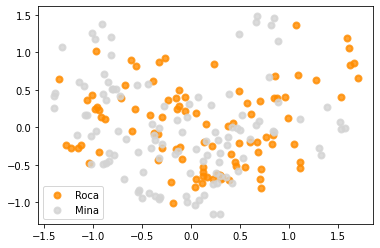

In [6]:
%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
pca_inputs = pca.fit_transform(inputs)

plt.figure()
colors = ["darkorange", "lightgray"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], ['Roca', 'Mina']):
    plt.scatter(
        pca_inputs[outputs == i, 0], pca_inputs[outputs == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)



El siguiente paso, ya que se van a comparar diferentes alternativas, sera dividir el conjunto de datos en entrenamieno y test. Para realizar este proceso, ya que se trata de un problema sencillo con sólo 2 posibles clases, lo más sencillo es extraer las matrices y dividir los conjuntos mediante la función `train_test_split`. En este caso se realizará un simple 
_hold_out_ simplemente con efectos meramente demostrativos, pero el procedimiento más adecuado hubiera sido un _cross-validation_ al ser un conjunto muy pequeño de datos. Por el mismo motivo, los pocos datos presente en lugar de realizar una división habitual 70:30 se reducirá ese montante de datos de test a solo un 10% del total. A mayores y para garantizar una cierta representatividad, la división se hará de manera estratificada, es decir, que las mismas proporciones se mantengan tanto en el entre las calses en el conjunto de test y el de entrenamiento.

In [7]:
from sklearn.model_selection import train_test_split

#Crear los conjuntos de entrenamiento y test
train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size=0.1, stratify=outputs)

#Una pequeña comprobación de programación defensiva
print(f"Train Patterns{train_inputs.shape} -> {train_outputs.shape}")
print(f"Test Patterns{test_inputs.shape} -> {test_outputs.shape}")

Train Patterns(187, 60) -> (187,)
Test Patterns(21, 60) -> (21,)


Es en este punto, una vez hecha la división es cuando se podrán realizar los tratamientos de los datos. Si faltasen datos o, como es este caso, los datos no estuvieran normalizados, será en este punto donde aplicar los diferentes tratamientos.
En concreto, como ya se vió antes, en este problema no hay datos ausentes y por lo tanto no será necesario rellenarlos ni completarlos en este caso. De haberlos las funciones más habituales para el tratamiento de los mismos son:

* [sklearn.impute.SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). Permite "rellenar" los datos ausentes bien con un valor o la media de los valores presentes.
* [sklearn.impute.IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html). Esta función permite la estimación de un parámetro en función de los restantes. Resaltar que, los modelos creados para la estimación, son realizados siguiendo una estrategia *round-robin*.
* [sklearn.impute.KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html). En este caso, el objeto creado rellenará los valores en función de un KNN creado sobre los datos de entrenamiento. Se seleccionaran aquellos patrones más cercanos, y se rellenarían los datos ausentes con la media de los $k$ vecinos más cercanos.

Lo que si sucede en este caso es que los datos no están normalizados. La normalización se podría realizar con los siguientes métodos:

* [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). En este caso la normalización se hace haciendo uso de la media y la desviación típica de cada característica. Es la opción predilecta si la característica en cuestión tiene una distribución Gaussiana. Para ello aplica la siguiente formula:
$$ \frac{x_i - \bar x}{\sigma(x)}$$
* [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Este objeto realiza la normalización dentro del rango de cada una de las características. Para ello usa el máximo y el mínimo de cada característica con la formula que se ve a continuación. Este tipo de normalización es el indicado cuando no se puede garantizar la distribución Gaussiana de los datos.
$$ \frac{x_i - min(x)}{max(x)-min(x)}$$
* [sklearn.preprocessing.RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). Similar al caso anterior, esta normalización realiza la normalización usando el primer y tercer cuartil. Es indicado cuando pueden existir outlayers que afectarían a la normalización
$$ \frac{x_i - Q_1(x)}{Q_3(x)-Q_1(x)}$$
* [sklearn.preprocessing.MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html). Este objeto divide cada uno de las características por el máximo en valor absoluto, de tal manera que ese valor sera 1, pero no se modificará el centroide de la distribución de la característica.
$$ \frac{x_i}{max(|x|)}$$
* [sklearn.preprocessing.Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html). En este caso, la normalización se aplica al patrón y no a las características. De tal forma que se aplicaría la siguiente normalización.
$$\frac{x_{ij}}{\sqrt{\sum_{j}x_{ij} ^2}}$$
En este caso se va a realizar dicha normalización entre los valores mínimo y máximo como se ve a continuación:


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Crear el método para la normalización de los datos
scaler = MinMaxScaler()

# Ajustarlo y hacer la transformación de los datos de entrenamiento
train_inputs = scaler.fit_transform(train_inputs)

# Con el objeto ajustado aplicar la transformación a los datos de entrada de test
test_inputs = scaler.transform(test_inputs)

#Comprobar la conversión imprimiendo los rangos
#TODO

## Estableciendo la línea base

Como se ha comentado anteriormente, los ensemble son un conjunto de clasificadores más "débiles" que nos permiten posteriormente superar los límites de estos mediante su unión. Es por ello que, antes de comenzar con los ensemble, será preciso disponer de algunos modelos de referencia que se unirán posteriormente en un metaclasificador. En el ejemplo siguiente se entrenan algunos modelos sencillos como son: un SVM con kernel RBF, una Regresión Lineal, un Naïve Bayes y un Árbol de Decisión

In [9]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 

#Definir los clasificadores
clfs = { 'SVM': svm.SVC(probability=True), 
         'LR': LogisticRegression(),
         'DT': DecisionTreeClassifier(max_depth=4),
         'NB':GaussianNB()}

base_models = [name for name in clfs.keys()]

# Realizar el entrenamiento de cada modelo y calcualr su valor de test (accuracy)
for key in clfs.keys():
    clfs[key].fit(train_inputs, train_outputs)
    acc = clfs[key].score(test_inputs, test_outputs)
    print(f"{key}: {(acc*100):.4f}%")

SVM: 85.7143%
LR: 85.7143%
DT: 76.1905%
NB: 61.9048%


#### Ejercicio
Amplíe el conjunto de modelo disponibles por ejemplo introduciendo variantes de SVM, otras aproximaciones como por ejemplo, K-NN, Kmeans (cuidado con este caso con la función `score`) o un MLP sencillo. Al menos otros 4 evitando introducir el RandomForest, AdaBoost o cualquier otro modelo que implique ela composición de modelos per sé, lo cuales se verán más adelante. 

Como se puede ver hay métodos que dan un buen resultado de ajuste desde el comienzo, si bien otros es posible que necesiten un mayor ajuste de los hiperparámetros del modelo. Todos estos modelos es lo que se consideran modelos simples o *'weak models'*, en las técnicas ensemble lo que se busca es combinar varios de estos modelos con el fin de mejorar el rendimiento global. 

# Combinando Modelos
A la hora de combinar los modelos existen diferentes estrategias según la tarea del modelo, es decir, si estamos clasificando o haciendo una regresión. En este caso nos vamos a centrar en la classificación, si bien para la regresión sería similar, habría que tener en cuenta el caracter contínuo de los valores a la hora de combinar las salidas.

En cuanto a la combinación de la classificación, existen principalmente dos maneras de combinar las salidas de varios clasificadores. Estas combinaciones reciben el nombre de Voto mayoritario y Voto mayoritario con pesos  

### Voto Mayoritario
Sin bien también se conoce como _Hard Voting_, como su nombre indica se basan en seleccionar la opción más votada entre las predichas entre los diferentes modelos. La implementación disponible en `scikit learn` realiza una suma de las predicciones para cada una de las clases y, posteriormente, saca la media dichas estimaciones. La opción seleccionada por mayoría entre los "expertos" de los cuales consta el *emsemble* es la seleccionada. Así, se podría resolver el problema teniendo en cuenta diferentes resultados o puntos de vista sobre el mismo. Véase un ejemplo en el código siguiente de construcción de un modelo como este.

In [10]:
from sklearn.ensemble import VotingClassifier

#Definir el metaclasificador con los clasificadores definidos previamente.
clfs['Ensemble (Hard Voting)'] = VotingClassifier (estimators = [(name,clfs[name]) for name in base_models], 
                                                   n_jobs=-1)
clfs['Ensemble (Hard Voting)'].fit(train_inputs, train_outputs)

for key in clfs.keys():
    acc = clfs[key].score(test_inputs, test_outputs)
    print(f"{key}: {(acc*100):.4f}%")

SVM: 85.7143%
LR: 85.7143%
DT: 76.1905%
NB: 61.9048%
Ensemble (Hard Voting): 80.9524%


Como se puede ver, si bien no mejora al mejor de los modelos que lo componen, esto se debe a, en primer lugar, que este no es un problema especialmente complejo. A mayores otro de los problemas es que nos fiamos por igual de todos los modelos a la hora de decidir la clase de respuesta. Para solucionar este problema se puede hacer que no todos los modelos tengan la misma importancia como veremos en el siguiente partado.

### Voto Mayoritario con Pesos
Como se indicó en el paso anterior, uno de los problemas del modelo clásico de *emsemble* es que todos los resultados pesan lo mismo y en cada uno de los modelos "débiles" sólo se contempla la opción más votada. Para solucionar esto una de las propuestas es el uso de de un peso en las ponderaciones de las decisiones. Esto se debe que un modelo puede ser mejor que otro o ser más confiable. Con el fin de reflejar este punto, se puede modificar dicha salida multiplicandola por un factor de confianza dentro de la regla utilizada para tomar las decisiones. Este procedimiento de ponderación en ocasiones también se denomina *Soft Voting* con el fin de contraponerlo al *Hard Voting* o no ponderado. Imagine que a cada uno de los clasificadores le asignamos el mismo peso, es decir {1,1,1}. En un ejemplo como el siguiente con un SVM, una regresión Logarítmica y un modelo basado en Bayes tendríamos las siguientes salidas.

|Classificador	     |Mina	        |Roca          |
| :------------- | :----------: | -----------: |
|SVM         	 | 0.9	    | 0.1      |	
|LR         	 | 0.3	    | 0.7      |	
|NB         	 | 0.2	    | 0.8      |
|Soft Voting      |0.47	        |0.63          |	

De esta manera la clase seleccionada sería la de Roca ya que todos los modelos pesan lo mismo en la toma de la decisión al realizar la media. En contra posición, si sabemos que uno de los modelos es mejor se puede ponderar la respuesta de dicho modelo. Imagine en el ejemplo anterior que se supiera que el ejemplo anterior, SVM suele ser mucho mejor que los otros dos para este problema en concreto. En ese caso, se puede inclementar su peso como se ve a continuación con el fin de tener dicho ejemplo más en cuenta. Con el mismo ejemplo pero, hacido que la respuesta de SVM sea mayor, los resultados serían:

|Classificador	     |Mina	        |Roca          |
| :------------- | :----------: | -----------: |
|SVM         	 |2 * 0.9	    |2 * 0.1      |	
|LR         	 |1 * 0.3	    |1 * 0.7      |	
|NB         	 |1 * 0.2	    |1 * 0.8      |
|Soft Voting      |0.575	        |0.425          |

Como se pude ver en los resultados, si tenemos un modelo de más calidad, las salidas de este se tendrán más en cuenta en cuanto a tomar la decisión correspondiente.

Para implementar este tipo de comportamiento se puede hacer simplemente añadiendo dos parámetros adicionales al a función `VotingClassifier` que se había usado previamente para que pondere la salida.

In [11]:
clfs['Ensemble (Soft Voting)'] = VotingClassifier (estimators = [(name,clfs[name]) for name in base_models], 
                                                   n_jobs=-1, voting='soft',weights=[1,2,2,1])
clfs['Ensemble (Soft Voting)'].fit(train_inputs, train_outputs)

for key in clfs.keys():
    acc = clfs[key].score(test_inputs,test_outputs)
    print(f"{key}: {(acc*100):.4f}%")

SVM: 85.7143%
LR: 85.7143%
DT: 76.1905%
NB: 61.9048%
Ensemble (Hard Voting): 80.9524%
Ensemble (Soft Voting): 80.9524%


Como se puede ver, los resultados son mejores cuando se combinan varios modelos que dan buenos resultados. De hecho, este procedimiento es la base de otras técnicas como son los *Random Forest* que veremos un poco más adelante en este tutorial. Los modelos a usar son la otra de las claves para la creación _ensemble_, en la siguiente sección veremos las estrategias más habituales para la creación de los modelos.

El ajuste de esos pesos puede hacerse de muchas maneras diferentes, por ejemplo, se puede hacer de manera manual como hemos hecho en el ejemplo anterior. Otra alternativa sería usar alguna técnica de gradiente descencente para ir ajustandolos como si se tratara de una red neuronal o un SVM. Otra posibilidad es usar el valor de ajuste sobre el conjunto de validación (en este caso no se ha reservado un conjunto de datos para tal fin) como peso de los modelos.

#### Ejercicio
Realice un ensemble diferente con otros modelos sobre el mismo conjunto de datos y ajuste los pesos con el fin de obtener un buen resultado.

## Creación de modelos

Uno de los elementos clave que todavía no se ha aborada es la crecación de los modelos que compondrán el metaclasificador. Hasta el momento, la aproximación que se ha seguido no es demasiado adecuada ya que el conjunto de datos de entrada de todos los modelos es el mismo. Esto tiene el efecto de una evidente falta de diversidad en los modelos ya que sea cual sea el modelo que creemos, este tendrá la misma información o "punto de vista" que los otros. Sin embargo, esto no es la práctica habitual si no que el conjunto de patrones de entrada se suele repartir en conjuntos más pequeños con los que entrenar una o varias técnicas con el fin de, por un lado, reducir el coste computacional y, por el otro, aumentar la divversidad en los modelos. Es necesario recordar en este punto que los modelos "débiles" no tienen que ser perfectos en todas las clases ni tan siquiera tienen porque contemplar todas las posibilidades sólo se necesitan modelos rápidos de entrenar y que ofrezcan una salida más o menos consistente.

En cuanto a la manera en al que repartir los datos para la creación de los modelos, la mayor parte de las aproximaciones suele contemplar dos aproximaciones principalmente conocidas como *Bagging* y *Boosting*. A continuación, sse describirán brevemente estas dos aproximaciones.

### Bagging o boostrap aggregation
La técnica conocida como _Bagging_ o selección con remplazo fue propuesta por Breitman en 1996. Se basa en el desarrollo de múltiples modelos los cuales se pueden entrenar en paralelo. El elemento clave de esos modelos es que, cada uno de los modelos, se entrena sobre un subconjunto del conjunto de entrenamiento. Este subconjunto de datos se extrae de manera aleatoria con remplazo. Este último punto es particularmente importante ya que una vez que un ejemplo ha sido seleccionado de las posibilidades, se coloca nuevamente entre las posibilidades para poder ser seleccionado ya sea en el subconjunto que se está construyendo, o en los subconjuntos de los otros modelos, o lo que es lo mismo se crean conjuntos no disjuntos de ejemplos.

<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 50%;"
    src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/440px-Ensemble_Bagging.svg.png" 
    alt="Ejemplo de Bagging">
</img>

Lo que provoca es que se crean "expertos" en datos especializados y dependiendo de la partición. Si bien los datos comunes, o más frecuentes, son correctamente contemplados por todos los modelos, también es cierto que los datos con menor frecuencia tienden a no estar en todas las particiones y pueden no ser contemplados en todos los casos. Así, se obtendrían modelos que estarían más especializados en determinados datos o que tienen un punto de vista diferente, que serían expertos en una región particular del espacio de búsqueda.

Si bien se hablará un poco más adelante en más detalle, una técnica muy conocida que usa está aproximación para la construcción de sus modelos "débiles" es RandomForest. Está construye los arboles de decision que componen el metaclasificador de esta manera. 

A continuación, se puede ver un ejemplo de implementación de un metaclasificador que utiliza está técnica pero con SVM como clasificador base.


In [12]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

clfs['Bagging (SVC)'] = BaggingClassifier(base_estimator=SVC(),n_estimators=10, max_samples=0.50, n_jobs=-1)
clfs['Bagging (SVC)'].fit(train_inputs, train_outputs)

for key in clfs.keys():
    acc = clfs[key].score(test_inputs,test_outputs)
    print(f"{key}: {(acc*100):.4f}%")

SVM: 85.7143%
LR: 85.7143%
DT: 76.1905%
NB: 61.9048%
Ensemble (Hard Voting): 80.9524%
Ensemble (Soft Voting): 80.9524%
Bagging (SVC): 85.7143%


Se puede usar cualquier classificador como base de un *Bagging* con la la clase [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html). En este caso, en el código, se ha optado por generar 10 modelos de de la clase `SVC`entrenados sólo sobre el 50% de los patrones de entrenamiento. 

Alternativamente a extraer ejemplos completos, se podría realizar una partición en vertical del _dataset_ de entrenameiento, extrayendo por tanto carácterísticas. Para implementar está alternativa, en la función `BaggingClassifier`se debe de definir el parámetro *max_features*. Esta aproximación se usa cuando el número de características es muy elevado para crear modelos más simples que no usen toda la información que en muchas ocasisones es redundante. Debe de destacarse que este procedimiento de extracción de caracterísitcas para los modelos se hace sin remplazo, es decir, las características sacadas para un clasificador no se vuelven a introducir en la lista de posibilidades hasta crear el conjunto para el siguiente clasificador.

### Boosting
La otra gran familia de técnicas para la creación de metamodelos de ensemble es lo que se conoce como *Boosting*. En este caso, la aproximación es ligeramente distinta, ya que lo que se pretende es crear una cadena de clasificadores. EL elemento clave de este tipo de clasificadores es buscar que, cada nuevo clasificador, este más especializado en los patrones que los modelos previos han errado. Por tanto, al igual que en el caso anterior, se selecciona un subconjunto de patrones del conjunto origianal. Sin embargo, este proceso se hace de manera secuencial y sin remplazo. Este punto es crucial ya que como se comentó la idea es eliminar aquellos patrones que están ya correctamente clasificadose e ir obtenido modelos más específicos que se concentran en aquellos ejemplos menos frecuentes o que han sido clasificados de manera incorrecta en un paso anterior. Por tanto, al igual que en el *Bagging*, la idea subyacente de esta aproximación es que no todos los modelos tengan que tener todos los patrones como base, pero a diferencia de _Bagging_, este proceso es lineal por la dependencia en la construcción de los modelos. 

<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 50%;"
    src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Ensemble_Boosting.svg/1920px-Ensemble_Boosting.svg.png" 
    alt="Ejemplo de Boosting">
</img>

Posteriormente, para obtener la combinación de los modelos, se hace uso del Voto Mayoritario con pesos. En dicha aproximación, los pesos es establecen con un sistema de aproximación iterativa. Existen multitud de ejemplos que utilizan este tipo de técnica como [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) o [Gracient Tree Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). En ambos casos lo que se realiza es un ajuste de los pesos con una técnica basada en el Gradiente Descendente. 

En el caso del AdaBoost, el algoritmo parte dandole un peso a todas las instancias del conjunto de entrenamiento. Con ese conjunto ponderado, se entrena un clasificador con esos datos originales. En función de los errores comentidos se ajustan los pesos del conjunto original y se entrena una nueva copía del clasificador, pero ya sobre esos datos ajustados que se centrarán más en las instancias que han sido clasificadas de manera incorrecta. En el caso de `scikit learn`, el algoritmo implementado es el conocido como [AdaBoost-SAMME](https://hastie.su.domains/Papers/SII-2-3-A8-Zhu.pdf) propuesto por Zhu et.al en 2009. Como particularidad de está implementación, comentar que la función de *loss* utilizada es una exponencial. Esta es la que se utilizará para calcular la ponderación de los errores cometidos, así como el peso de los clasificadores en el metaclasificador. En terminos generales, la salida será la más votada por los clasificadores en base a la ponderación de cada uno de ellos. 

Por su parte, el Gradiente Tree Boosting es una aproximación diferente del uso del _Boosting_. Ésta construye un árbol en donde los nodos del árbol establecen los criterios de, por ejemplo,  en el caso de la clasificación hacen referencia al `logistic-likelihood` de un determinado patrón. De esa manera, cada una de los nodos del arbol se realiza una clasificación la cual se va ajustando en base a los errores residuales que se van cometiendo ajustando los pesos de los diferentes clasificadores del árbol. Esta división se realiza para cada una de las características de que se dispone, realizando un procedimiento recursivo entrenando varios clasificadores de esta manera. Posteriormente, para hacer la toma de decisión, ésta se basa en las respuestas de los clasificadores por los que ha ido pasando. La principal diferencia con el AdaBoost es que en este caso la salida son las probabilidades de las clases las cuales se suman para dar la respuesta más probable en lugar de que sea la respuesta sobre la instancias.

A continuación, vemos una aproximación con un  se puede ver un ejemplo de uso de estos dos metaclasficadores que hacen uso de _Boosting_.

In [13]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

clfs['Ada'] = AdaBoostClassifier(n_estimators=30)
clfs['Ada'].fit(train_inputs, train_outputs)

clfs['GTB'] = GradientBoostingClassifier(n_estimators=30, learning_rate=1.0, max_depth=2, random_state=0)
clfs['GTB'].fit(train_inputs, train_outputs)

for key in clfs.keys():
    acc = clfs[key].score(test_inputs,test_outputs)
    print(f"{key}: {(acc*100):.4f}%")


SVM: 85.7143%
LR: 85.7143%
DT: 76.1905%
NB: 61.9048%
Ensemble (Hard Voting): 80.9524%
Ensemble (Soft Voting): 80.9524%
Bagging (SVC): 85.7143%
Ada: 80.9524%
GTB: 80.9524%


#### Ejercicio
Repita el ejercicio anterior pero cambiando el classificador base de `AdaBoostClassifier` y en el caso del `GradientBoostingClassifier`, si bien este no se puede cambiar el clasificador base, consulte la documentación y cambie los parámetros necesarios para que al menos haya 4 patrones en cada uno de los clasificadores terminales del árbol.

## Técnicas que integran la aproximación _Ensemble_

Algunos de los algoritmos más conocidos y usados actualmente se basan en este tipo de aproximación. De entre esas aproximaciones, puede que las más famosas y utilizadas son aquellas que toman como base la generación de sencillos árboles de decisión (_Decision Tree, DT_). La razón del uso de los árboles es su fácil interpretación, así como la rapidez en el cálculo y entrenamiento. A continuación se verán las dos aproximaciones conocidas a día de hoy en este sentido, ***Random Forest*** y ***XGBoost***.


### Random Forest
Este algoritmo, propuesto por Breitman y Cutler en 2006 a instancias de una publicación anterior de Ho de 1995 (_Random Subspaces_), es el paradigma de técnica de ensemble. El algoritmo une en un ensemble un conjunto de clasificadores sencillos que toman la forma de *Decision Trees*. Estos clasificadores son entrenados siguiendo una aproximación de *bagging*, y por lo tanto se pueden entrenar cada uno de forma paralela. Para combinar la salidad de los algoritmos se hace para los problemas de clasificación mendiante la opción más votada entre los "expertos" o, si es un problema de regresión, mediante la media aritmética de las respuestas. 

Es un algoritmo que necesita el ajuste de muy pocos hiperparámetros para obtener muy buenos resultados en casi cualquier tipo de problema. En general, el valor más importante es el número de estimadores y por tanto el número de particiones que se va a hacer del conjunto de entrenamiento. Varios autores apuntan que ese número de estimadores debiera de ser *$\sqrt{\textrm{número características}}$* para problemas de clasicación, y *$\frac{\textrm{número características}}{3}$ para problemas de regresión. Aun así, también apunta que la técnica saturaría entre 500 y 1000 árboles y por mucho que se aumente no mejoraría resultados. Si bien este último dato solo ha sido probado de manera empírica en determinados conjuntos de datos y por lo tanto debe de ser tomado con cuidado al no tener una justificación matemática.

A mayores del proceso habitual de *bagging*, los *Random Forest* también incluyen un segundo mecanismo de división. Una vez seleccionados los patrones que formaran parte del conjunto de entrenamiento del árbol de decisión, solamente un subconjunto de características (*features*) aleatorias están disponibles para cada nodo del árbol. Esto hace crecer la diversidad de los árboles del bosque y lo que consigue es centrarse en el rendimiento global con una pequeña varianza en los resultados. Este mecanísmo permite evaluar cuantitativamente el rendimiento individual de cada árbol que forma parte del bosque y sus variables. Por tanto, se puede medir la importancia de cada variable. Está medida que calibra la participación de cada variable en nodos del árbol en la toma de decisiones se denomina impureza y viene a medir la diferencia entre las diferentes ramas del árbol cuando se hace la partición de los ejemplos. En ocasiones, esta misma medida es utilizada a modo de medida para la selección de variables tomando la medida en todos los árboles del bosque de la participación e importancia mediante un filtrado como los vistos en la unidad anterior.

Para el calculo de esa medida de impureza, existen diferentes aproximaciones. Por ejemplo, `scikit learn` utiliza una medida que denomina **Gini**. Esta última es la probabilidad de clasificar incorrectamente un elemento elegido al azar en el conjunto de datos si se etiquetara aleatoriamente según la distribución de clases en el conjunto de datos. Se calcula como:
$$G = \sum_{i=1}^C p(i) * (1 - p(i))$$

siendo $C$ el número de clases y $p(i)$ la probabilidad de seleccionar al azar un elemento de la clase $i$. Se puede ver un buen ejemplo de como calcular la impureza de las ramas en el siguiente [enlace](https://victorzhou.com/blog/gini-impurity/)

A continuación, sobre el ejemplo que se viene utilizando en esta unidad, se ejecutará un modelo de *Random Forest* con la implementación de `scikit learn`. Destacar como parámetros más importante de dicha implementación:

- ***n_estimator***, que marca el número de árboles que se van a generar o el número de particiones de *bagging*.
- ***criterion***, medida de impureza de los nodos. Por defecto se usa Gini aunque puede cambiarse por la entropía ganada.
- ***max_depth***, permite limitar la profundidad máxima de los árboles para así limitar el número de variables a usar.
- ***min_sample_split***, para cada árbol de decisión, cuantos patrones son necesario para realizar una división interna en los *Decision Trees*.
- ***bootstrap***, puede utilizar la aproximación de *bagging* o *bootstrap* para construir los árboles pero si esta propiedad es falsa, entonces usa todo el conjunto de entrenamiento para generar los árboles. En caso de tener un valor True, se tienen en cuenta las siguientes propiedades:
    + ***max_samples***, número de ejemplos a extraer del conjunto original para construir el conjunto de entrenamiento del estimador, el valor por defecto es igual al número de patrones pero recuerde que puede extraerse varias veces el mismo ya que es una selección con remplazo dando variabilidad.
    + ***oob_score***, medida de *out of bag* para estimar la generalización. Aquellas muestras que no han formado parte del entrenamiento de un estimador se pueden usar para calcular una medida de validación y, promediarla entre todos los estimadores para saber como de general es el bosque construído.
 

In [21]:
from sklearn.ensemble import RandomForestClassifier

clfs['RF'] = RandomForestClassifier(n_estimators=8, max_depth=None,
                                    min_samples_split=2, n_jobs=-1)

clfs['RF'].fit(train_inputs, train_outputs)
for key in clfs.keys():
    acc = clfs[key].score(test_inputs,test_outputs)
    print(f"{key}: {(acc*100):.4f}%")

SVM: 85.7143%
LR: 85.7143%
DT: 76.1905%
NB: 61.9048%
Ensemble (Hard Voting): 80.9524%
Ensemble (Soft Voting): 80.9524%
Bagging (SVC): 85.7143%
Ada: 80.9524%
GTB: 80.9524%
RF: 76.1905%


En esta aproximación se han definido el número de estimadores siguiendo la regla antes indicada de $\sqrt{\textrm{número características}}$. En este caso como son pocos estimadores y pocos patrones los resultados pueden variar bastante en función del tipo de particiones obtenidas.

A continuación, una vez entrenado el modelo, se puede comporobar el nivel de impureza obtenido para cada una de las frecuencias que se ha calculado con el el algoritmo Gini, como una media de las obtenidas entre los arboles que componen el bosque. 

Text(0.5, 1.0, 'Valores de importancia de las características ')

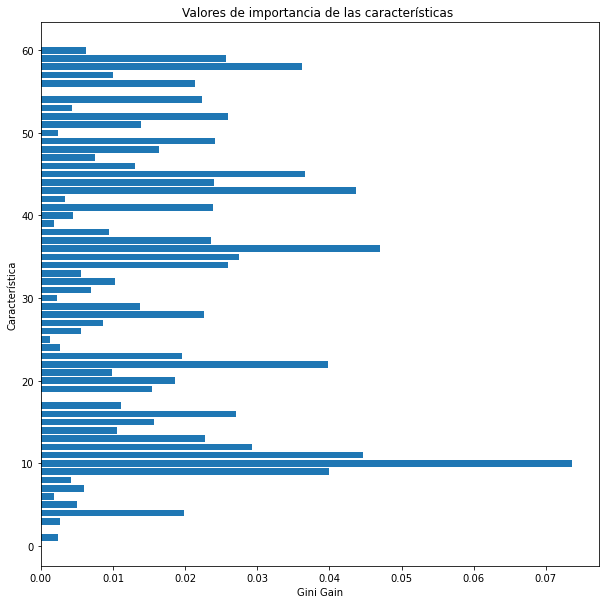

In [29]:
#for name, score in enumerate(clfs['RF'].feature_importances_):
#    print(f"Feature {name+1} score: {score:.4f}")
    
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"]=10,10
plt.barh(y=range(1,61), width = clfs['RF'].feature_importances_)
plt.xlabel("Gini Gain")
plt.ylabel("Característica")
plt.title("Importancia de las características ")


A puntar que , como se ve en el gráfico, este valor determina que la mayor parte de la información se concentra en algunas de las frecuencias utilizadas. Es por ello, que como se comento antes, se podría realizar un filtrado de la información como el visto en la unidad anterior en base a este valor. 

### XGBoost (eXtreme Gradient Boosting)

Finalmente, en este último apartado destacar nuevamente el Gradient Boosting, en concreto, una implementación que en los últimos años se ha hecho muy famosa por su versatilidad y rapidez. Esta implementación que se conoce como ***XGBoost (eXtreme Gradient Boosting)*** , que ha destacado sobre todo en competiciones como en la plataforma Kaggle por su rápidez en la obtención de resultados y robustez de los mismos. 

El ***XGBoost*** será un ensemble similar al de los Random Forest pero utiliza un clasificador base diferente conocido como CART (classification and regression trees) en lugar de *Decision Trees*. Este cambio viene de la mano de la necesidad del algoritmo de obtener la  probabilidad de las decisiones, al igual que ocurría con el *Gradient Tree Boosting*. El otro de los cambios fundamentales de este algotimo es, ya que está basado en el * Gradiente Tree Boosting*, es el cambio de la estrategia de *bagging* por la de *boosting* para la creación de los conjuntos de entrenamiento de los clasificadores.

Posteriormente, está técnica realiza una aproximación de entrenamiento aditivo cuyos pesos se van ajustanto en base a un **Gradiente Descendente** sobre una función de *loss* a definir. Sumando la función de *loss* con el término de regularización, se puede calcular hasta la segunda derivada de las funciones con el fin de actualizar los pesos de la clasificación realizado por los diferentes árboles. El cálculo de este gradiente, permite por lo tanto el ajuste de los valores de los clasificadores que se generan a continuación de uno dado con el fin de que los pesos permitan focalizar la atención en los patrones que incorrectamente clasificados. Los detalles matemáticos de la implementación se pueden consultar en este [enlace](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).

Al diferencia del resto de aproximaciones que hemos visto, el `xgboost` no se encuentra actualmente implementado en `scikit learn`. POr este motivo, se deberá de instalar la versión de referencia si no está ya presente en la máquina.

In [33]:
try:
    import xgboost as xgb
except ModuleNotFoundError:
    !pip install xgboost
    import xgboost as xgb

Tras esa instalación, se podría hacer uso de la librería como se ve en el ejemplo siguiente. En primer lugar, para hace uso de está librería es necesario hacer una adapción de los datos de entrada al formato [LIBSVM](https://xgboost.readthedocs.io/en/stable/tutorials/input_format.html). Existen varias formas de cargar los datos desde numpy, scipy o pandas, para mayores detalles sobre este punto y para aplicarlo a diferentes problemas, se pude consultar el siguiente enlace [enlace](https://xgboost.readthedocs.io/en/stable/python/python_intro.html). En este caso concreto, el ejemplo está almacenado en un array de `numpy` con lo que para la transformación de los datos bastaría con:

In [34]:
# preparar las matrices para usarlas con el formato LIBSVM
dtrain = xgb.DMatrix(train_inputs, label=train_outputs)
dtest = xgb.DMatrix(test_inputs, label=test_outputs)

Una vezz realizada está adaptación de los datos, se puede proceder con el entrenamiento de un modelo de la librería `xgboost`. Para ello sólo hará falta llamar a la función train con los parámetros correspondientes. Dentro de estos parámetros destacan:

- **eta**, término que determinará la compresión de los pesos tras cada nueva etapa del *boosting*. Toma valores entre 0 y 1.
- **max_depth**, profundidad máxima de los árboles tiene por defecto un valor de 6 incrementarlo lo que hará será permitir modelos más complejos
- **gamma**, parámetro que controla la reducción mínima de pérdidas necesaria para realizar una nueva partición en un nodo hoja del árbol. Cuanto mayor sea será más conservador
- **alpha** y **lambda**, son los parámetros que controlan la regulación L1 y L2 respectivamente.
- **objective**, establece la fución de loss a ser utilizada que puede ser una de las predefinidas, las cuáles se pueden consultar en este [enlace](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster)

A mayores solo es necesario establecer el número máximo de iteraciones del proceso de boosting como se ve en el siguiente ejemplo con 40 rondas.

In [36]:
# Especificar los parámetros del modelo
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 40

# entrenar el modelo correspondiente
xgb_model = xgb.train(param, dtrain, num_round)

[12:40:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


***NOTA***

En caso de usarse un conjunto de validación, este debe de pasarse en el parámetro *evals* de la función de entrenamiento. A mayores, y sólo cuando el mencionado parámetro *evals* está definido, se puede establecer las rondas para la parada previa con el parámetro *early_stopping_rounds* de la función de entrenamiento. El código sería similar a:
``` python
    evals = xgb.DMatrix(val_inputs, label=val_outputs)
    xgb_model = xgb.train(param, dtrain, num_round, evals=evals, early_stopping_rounds=10)
```

El valor proporcionado en la salida se corresponde con la suma de las salidas de los árboles, estándo está entre 0 y 1 apra la pertenencia a una determinada clase. Como se trata de un es una clase binaria, simplemente se establece un límite de 0.5 a la salida para determinar cual es la respuesta.

In [41]:
from sklearn.metrics import accuracy_score

print(f"{xgb_model.predict(dtest)}")

# Evaluar la salida
acc = accuracy_score(xgb_model.predict(dtest)>0.5,test_outputs)
print(f"XGB: {(acc*100):.4f}%")

[8.4760702e-01 5.1304615e-01 9.5305294e-01 3.7761524e-04 9.9571759e-01
 1.2167676e-01 5.5907309e-01 9.9939620e-01 5.7567203e-01 1.8412283e-02
 8.8869894e-01 9.0951115e-01 9.9960881e-01 1.4012090e-02 9.9484211e-01
 5.5841553e-01 9.9324566e-01 9.9944490e-01 9.9865578e-02 2.3036277e-02
 9.9296373e-01]
XGB: 80.9524%


Finalmente, al igual que en el caso de los *Random Forest* es posible identidicar la importancia y pintarla para cada una de las variables en la clasificación. Con el siguiente código se pude ver dicho marcador ordenado decendentemente

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

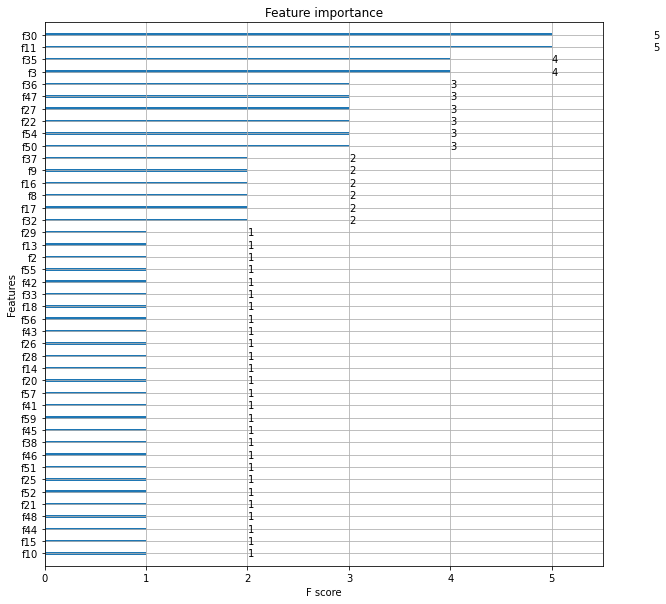

In [42]:
# imprimir la importancia de las características
xgb.plot_importance(xgb_model)

#### Ejercicio
En el siguiente [enlace](https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings) se describe un problema de clasificación. Dicho toma son las grabaciones de una serie de sonidos emitidos por 20 pacientes diagnosticados de la enfermedad de Parkinson y 20 sujetos sanos. A cada uno de ellos se les hace repetir una serie de números, vocales y consonantes, recogiendo en cada uno de ellos 27 propiedades de la audición. A mayores de estas 27 características, el problema cuenta, en la primera columna, con el identificador del sujeto y, en la última a la clase a la que pertenece. En el fichero asosciado existen dos ficheros txt, utilice solo el de entrenamiento train_data tanto para entrenamiento como para test diviediéndolo en un porcentaje de 90:10 entre entrenamiento y test.

Aplique las técnicas tanto de *Random Forest* como de *XGBoost* al problema descrito teniendo como objetivo el poder clasificar a los pacientes.

**IMPORTANTE** Los patrones proceden de un conjunto de voluntarios, a la hora de dividir los conjuntos de entrenamiento y test es importante el tenerlo presente. Ningun patrón perteneciente a un voluntario debiera de estar repartido entre los conjuntos de entrenamiento y test. Este esquema de división del es lo que se denomina un ***Subject-wise*** y en ámbitos como el médico es esencial para garantizar la correcta generalización de los modelos por lo tanto tengalo presente a la hora de dividir los datos.